In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = "final_data_for_analysis.csv"  # Replace with the actual file path
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Claim_Date                 771 non-null    object
 1   Employee_Name              776 non-null    object
 2   Employee_ID                776 non-null    int64 
 3   Designation                776 non-null    object
 4   Project_Name               696 non-null    object
 5   Email_address              775 non-null    object
 6   Total_Persons              776 non-null    int64 
 7   Allowable_Amount           776 non-null    int64 
 8   Total_Bill_Amount          776 non-null    object
 9   List_of_Persons_(as JSON)  757 non-null    object
 10  Seating_Location           776 non-null    object
 11  Bill_Date                  776 non-null    object
 12  Bill_No                    774 non-null    object
 13  Bill_day                   776 non-null    object
 14  Computed_T

In [4]:
# Convert date columns to datetime format
date_columns = ['Claim_Date', 'Bill_Date', 'Bill_Date_Friday']
df[date_columns] = df[date_columns].apply(pd.to_datetime, format='%d-%m-%Y', errors='coerce')

# Convert numerical columns to integer or float
df['Employee_ID'] = df['Employee_ID'].astype('int64')
df['Total_Persons'] = df['Total_Persons'].astype('int64')
df['Allowable_Amount'] = df['Allowable_Amount'].astype('int64')
df['Computed_Total_Persons'] = df['Computed_Total_Persons'].astype('int64')

# Convert 'Total_Bill_Amount' to numeric (handling non-numeric cases)
df['Total_Bill_Amount'] = pd.to_numeric(df['Total_Bill_Amount'], errors='coerce')

# Convert 'Mismatch' to boolean
df['Mismatch'] = df['Mismatch'].astype('bool')

# Fill missing values in categorical columns with 'Unknown'
categorical_columns = ['Project_Name', 'Email_address', 'Bill_No']
df[categorical_columns] = df[categorical_columns].fillna('Unknown')


In [5]:
# Calculate per-person expenditure
df['Per_Person_Expenditure'] = df['Total_Bill_Amount'] / df['Total_Persons']

In [6]:
# Group by group size and calculate average per-person expenditure
group_size_analysis = df.groupby('Total_Persons')['Per_Person_Expenditure'].agg(['mean', 'count']).reset_index()
group_size_analysis.columns = ['Group_Size', 'Avg_Per_Person_Expenditure', 'Count']

In [7]:
# Calculate percentage change from individual claims
base_value = group_size_analysis.loc[group_size_analysis['Group_Size'] == 1, 'Avg_Per_Person_Expenditure'].values[0]
group_size_analysis['Percentage_Change'] = ((group_size_analysis['Avg_Per_Person_Expenditure'] - base_value) / base_value * 100).round(2)


c:\Users\DYNABOOK\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


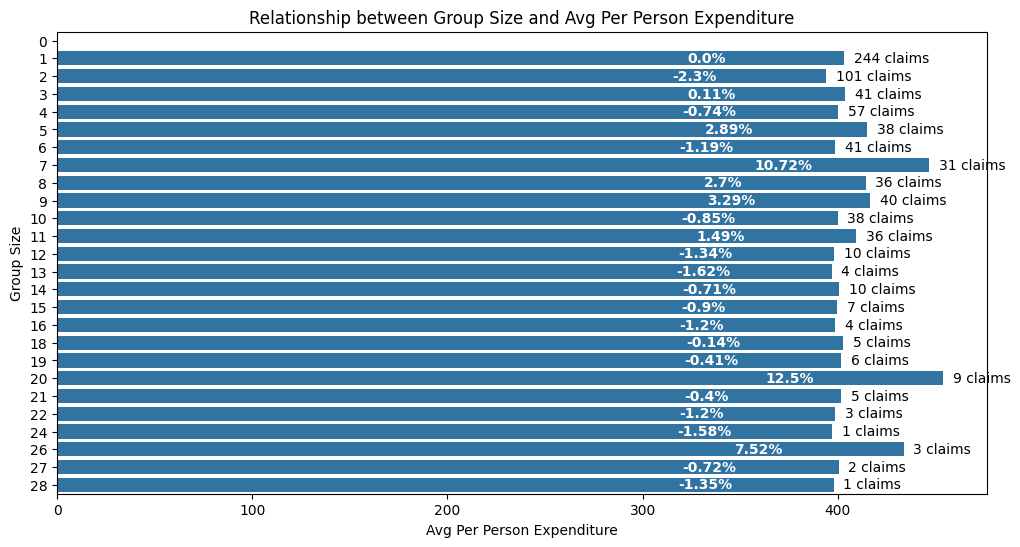

In [8]:
plt.figure(figsize=(12, 6))

# Create horizontal bar plot
sns.barplot(y='Group_Size', x='Avg_Per_Person_Expenditure', data=group_size_analysis, orient='h')

# Add labels for count and percentage change
for i, row in enumerate(group_size_analysis.itertuples()):
    # Claims label (placed to the right of the bar)
    plt.text(row.Avg_Per_Person_Expenditure + 5, i, f'{row.Count} claims', va='center')

    # Percentage change label (placed inside the bar, shifted left for readability)
    plt.text(row.Avg_Per_Person_Expenditure * 0.8, i, f'{row.Percentage_Change}%', va='center', color='white', fontweight='bold')

# Show plot
plt.xlabel('Avg Per Person Expenditure')
plt.ylabel('Group Size')
plt.title('Relationship between Group Size and Avg Per Person Expenditure')
plt.show()

In [10]:
import numpy as np
# Step 1: Replace inf values with NaN
group_size_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Drop rows with NaN values (including previously inf values)
group_size_analysis.dropna(inplace=True)

# Step 3: Recalculate correlation
correlation = group_size_analysis['Group_Size'].corr(group_size_analysis['Avg_Per_Person_Expenditure'])

print(f"Correlation: {correlation}")

Correlation: 0.032467211491048274


The correlation between Group Size and Avg Per-Person Expenditure is 0.037, which is very close to zero.

This indicates that there is no clear relationship between the number of people in a group and how much each person spends on average.

In [11]:
print("\nBasic Analysis Results:")
print(group_size_analysis[['Group_Size', 'Avg_Per_Person_Expenditure', 'Count', 'Percentage_Change']])


Basic Analysis Results:
    Group_Size  Avg_Per_Person_Expenditure  Count  Percentage_Change
1            1                  403.311352    244               0.00
2            2                  394.031188    101              -2.30
3            3                  403.755854     41               0.11
4            4                  400.307018     57              -0.74
5            5                  414.952632     38               2.89
6            6                  398.520325     41              -1.19
7            7                  446.544608     31              10.72
8            8                  414.215278     36               2.70
9            9                  416.566667     40               3.29
10          10                  399.873684     38              -0.85
11          11                  409.338384     36               1.49
12          12                  397.916667     10              -1.34
13          13                  396.769231      4              -1.62
14       

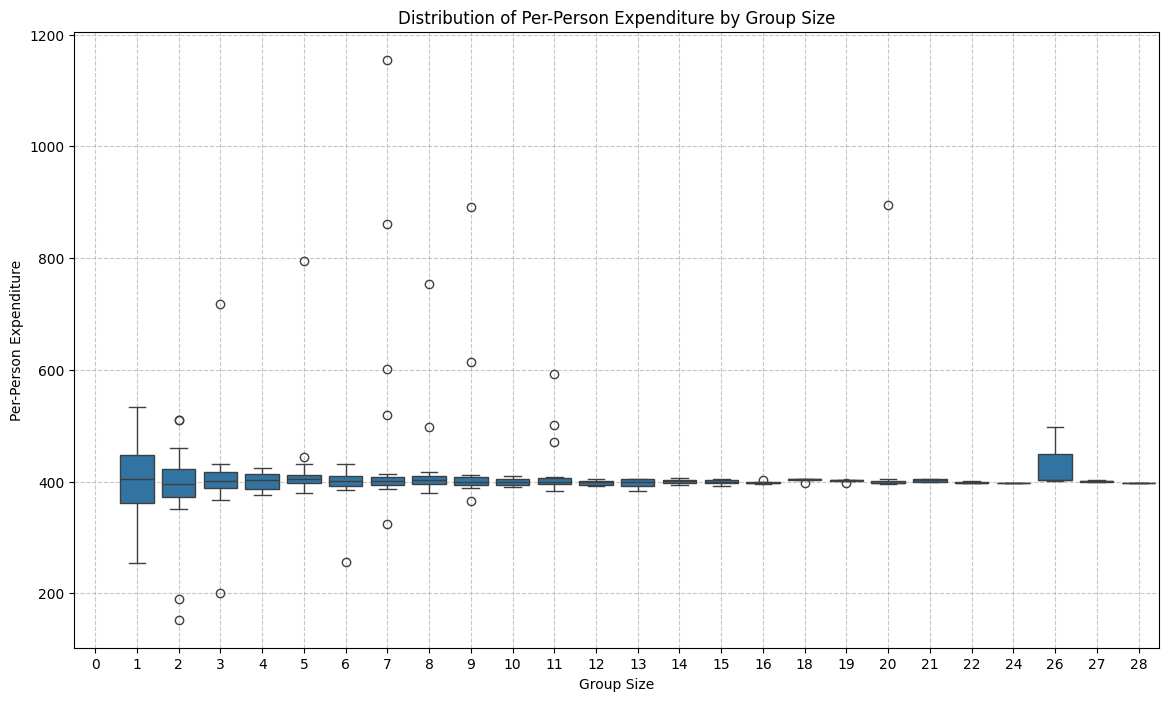

In [12]:
# Create boxplot to show distribution by group size
plt.figure(figsize=(14, 8))
sns.boxplot(x='Total_Persons', y='Per_Person_Expenditure', data=df)
plt.title('Distribution of Per-Person Expenditure by Group Size')
plt.xlabel('Group Size')
plt.ylabel('Per-Person Expenditure')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('distribution_analysis.png')


In [13]:
# Calculate percentiles for each group size
percentiles = [25, 50, 75]
percentile_analysis = df.groupby('Total_Persons')['Per_Person_Expenditure'].quantile(
    [p/100 for p in percentiles]).unstack().reset_index()
percentile_analysis.columns = ['Group_Size'] + [f'Percentile_{p}' for p in percentiles]


In [14]:

# Calculate the range (75th - 25th percentile)
percentile_analysis['IQR'] = percentile_analysis['Percentile_75'] - percentile_analysis['Percentile_25']

# Calculate coefficient of variation (std/mean) to measure consistency
cv_analysis = df.groupby('Total_Persons')['Per_Person_Expenditure'].agg(['mean', 'std']).reset_index()
cv_analysis['CV'] = (cv_analysis['std'] / cv_analysis['mean'] * 100).round(2)
cv_analysis = cv_analysis[['Total_Persons', 'CV']]
cv_analysis.columns = ['Group_Size', 'Coefficient_of_Variation']

In [15]:
distribution_analysis = pd.merge(percentile_analysis, cv_analysis, on='Group_Size')

# Print the results
print("\nDistribution Analysis Results:")
print(distribution_analysis)


Distribution Analysis Results:
    Group_Size  Percentile_25  Percentile_50  Percentile_75        IQR  \
0            0            NaN            NaN            NaN        NaN   
1            1     361.750000     405.000000     447.000000  85.250000   
2            2     371.500000     396.000000     422.000000  50.500000   
3            3     388.333333     401.323333     416.333333  28.000000   
4            4     386.500000     402.000000     412.750000  26.250000   
5            5     397.250000     403.900000     411.850000  14.600000   
6            6     391.833333     401.166667     409.166667  17.333333   
7            7     394.142857     401.428571     407.571429  13.428571   
8            8     395.062500     403.625000     410.093750  15.031250   
9            9     394.527778     398.555556     407.888889  13.361111   
10          10     394.325000     400.000000     404.050000   9.725000   
11          11     394.909091     398.727273     405.931818  11.022727   
12    

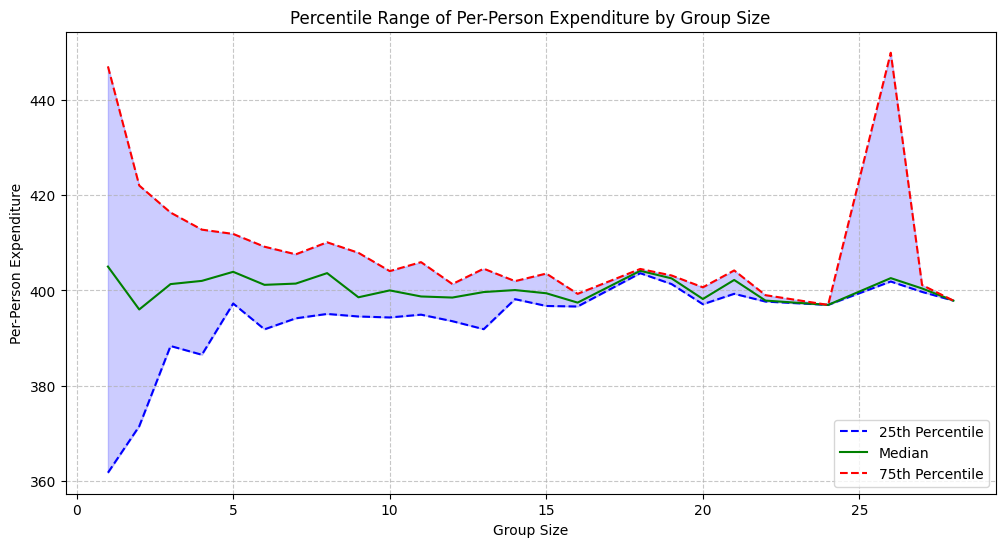

In [16]:
# Visualize the spread
plt.figure(figsize=(12, 6))
plt.plot(distribution_analysis['Group_Size'], distribution_analysis['Percentile_25'], 'b--', label='25th Percentile')
plt.plot(distribution_analysis['Group_Size'], distribution_analysis['Percentile_50'], 'g-', label='Median')
plt.plot(distribution_analysis['Group_Size'], distribution_analysis['Percentile_75'], 'r--', label='75th Percentile')
plt.fill_between(distribution_analysis['Group_Size'], 
                distribution_analysis['Percentile_25'],
                distribution_analysis['Percentile_75'], 
                alpha=0.2, color='blue')
plt.title('Percentile Range of Per-Person Expenditure by Group Size')
plt.xlabel('Group Size')
plt.ylabel('Per-Person Expenditure')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('percentile_analysis.png')

In [17]:
# Calculate the percentage of claims within different spending ranges for each group size
expenditure_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500),(500, 600),(600, 700),(700, float('inf'))]
range_counts = {}

for size in df['Total_Persons'].unique():
    size_data = df[df['Total_Persons'] == size]['Per_Person_Expenditure']
    counts = []
    for lower, upper in expenditure_ranges:
        count = ((size_data >= lower) & (size_data < upper)).sum()
        percentage = count / len(size_data) * 100 if len(size_data) > 0 else 0
        counts.append(percentage)
    range_counts[size] = counts

In [18]:
# Convert to DataFrame for visualization
range_df = pd.DataFrame(range_counts).T
range_df.columns = [f'{lower}-{upper}' for lower, upper in expenditure_ranges]
range_df = range_df.reset_index()
range_df.columns = ['Group_Size'] + list(range_df.columns[1:])


<Figure size 1400x800 with 0 Axes>

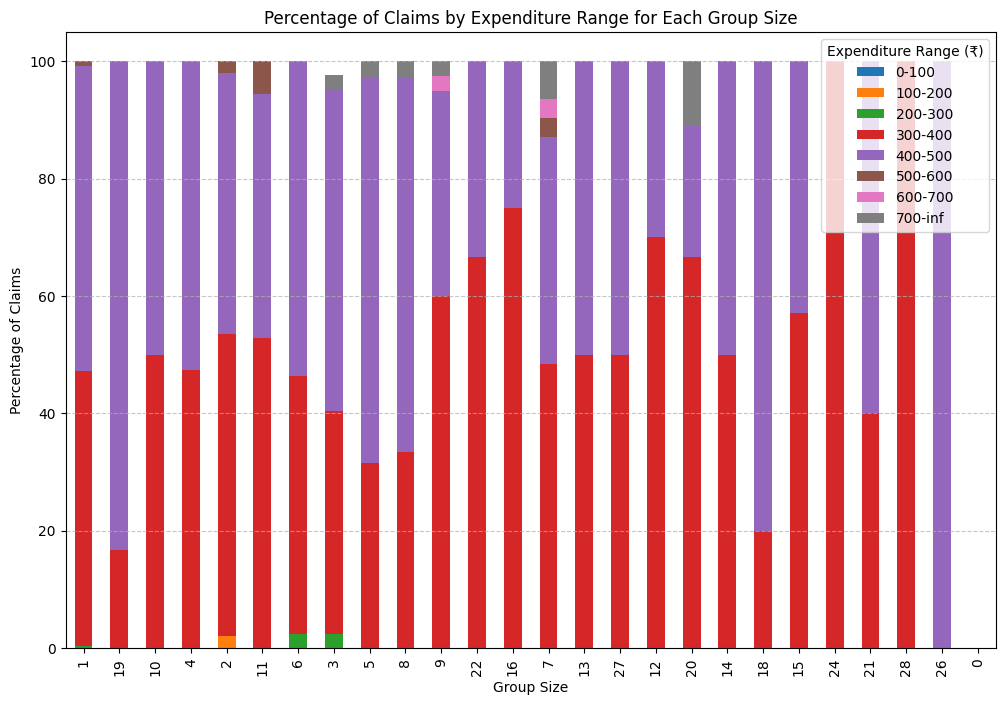

In [19]:
plt.figure(figsize=(14, 8))
range_df.set_index('Group_Size').plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Percentage of Claims by Expenditure Range for Each Group Size')
plt.xlabel('Group Size')
plt.ylabel('Percentage of Claims')
plt.legend(title='Expenditure Range (₹)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.savefig('expenditure_range_analysis.png')

In [20]:
# Calculate per-person expenditure by group size and location
location_analysis = df.groupby(['Seating_Location', 'Total_Persons'])['Per_Person_Expenditure'].mean().reset_index()
location_analysis.columns = ['Location', 'Group_Size', 'Avg_Per_Person_Expenditure']

# Calculate the base values (individual claims) for each location
location_bases = location_analysis[location_analysis['Group_Size'] == 1].set_index('Location')['Avg_Per_Person_Expenditure'].to_dict()

# Calculate percentage changes
location_analysis['Base_Value'] = location_analysis['Location'].map(location_bases)
location_analysis['Percentage_Change'] = ((location_analysis['Avg_Per_Person_Expenditure'] - location_analysis['Base_Value']) / 
                                         location_analysis['Base_Value'] * 100).round(2)

# Count the number of claims in each category
claim_counts = df.groupby(['Seating_Location', 'Total_Persons']).size().reset_index()
claim_counts.columns = ['Location', 'Group_Size', 'Count']
location_analysis = pd.merge(location_analysis, claim_counts, on=['Location', 'Group_Size'])


<Figure size 1400x800 with 0 Axes>

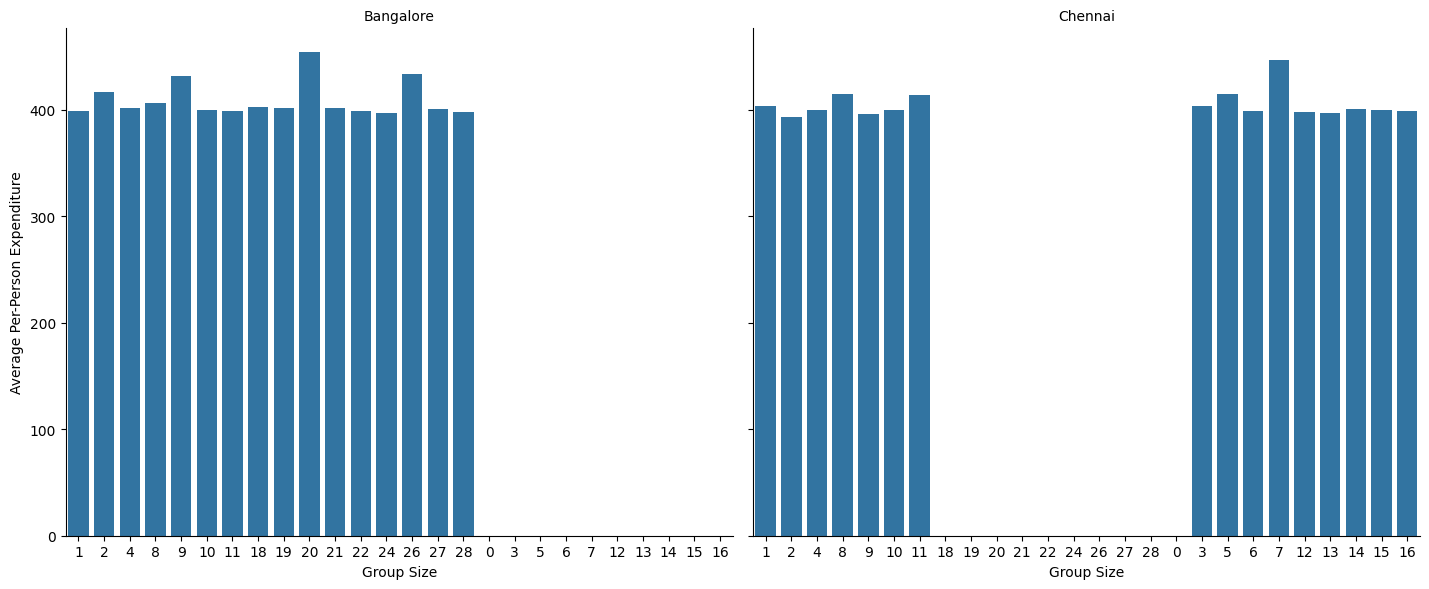

In [21]:
plt.figure(figsize=(14, 8))
g = sns.FacetGrid(location_analysis, col='Location', height=6, aspect=1.2)
g.map_dataframe(sns.barplot, x='Group_Size', y='Avg_Per_Person_Expenditure')
g.set_axis_labels('Group Size', 'Average Per-Person Expenditure')
g.set_titles('{col_name}')
g.tight_layout()
plt.savefig('location_based_analysis.png')

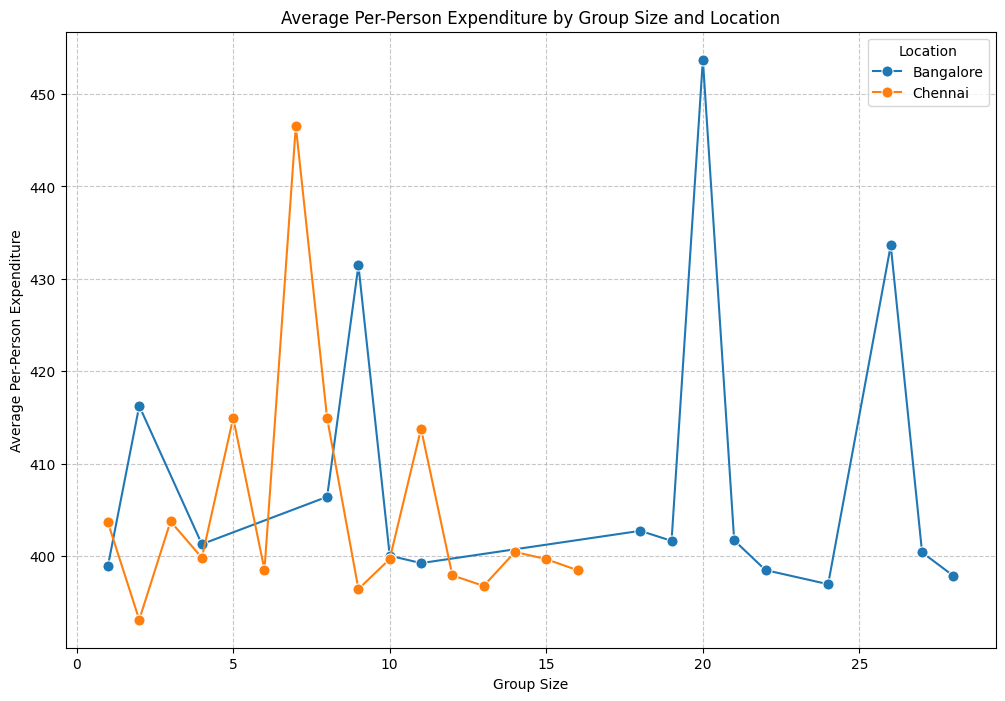

In [22]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=location_analysis, x='Group_Size', y='Avg_Per_Person_Expenditure', 
            hue='Location', marker='o', markersize=8)
plt.title('Average Per-Person Expenditure by Group Size and Location')
plt.xlabel('Group Size')
plt.ylabel('Average Per-Person Expenditure')
plt.grid(True, linestyle='--', alpha=0.7)

In [23]:
correlations = {}
for location in df['Seating_Location'].unique():
    loc_data = df[df['Seating_Location'] == location]
    corr = loc_data['Total_Persons'].corr(loc_data['Per_Person_Expenditure'])
    correlations[location] = corr

# Print the results
print("\nLocation-Based Analysis Results:")
for location, groups in location_analysis.groupby('Location'):
    print(f"\n{location}:")
    print(groups[['Group_Size', 'Avg_Per_Person_Expenditure', 'Percentage_Change', 'Count']])
    print(f"Correlation: {correlations[location]:.4f}")


Location-Based Analysis Results:

Bangalore:
    Group_Size  Avg_Per_Person_Expenditure  Percentage_Change  Count
0            1                  398.929412               0.00     17
1            2                  416.250000               4.34      4
2            4                  401.289474               0.59     19
3            8                  406.416667               1.88      3
4            9                  431.449275               8.15     23
5           10                  400.045000               0.28     20
6           11                  399.239669               0.08     11
7           18                  402.733333               0.95      5
8           19                  401.649123               0.68      6
9           20                  453.711111              13.73      9
10          21                  401.704762               0.70      5
11          22                  398.484848              -0.11      3
12          24                  396.958333              -

c:\Users\DYNABOOK\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


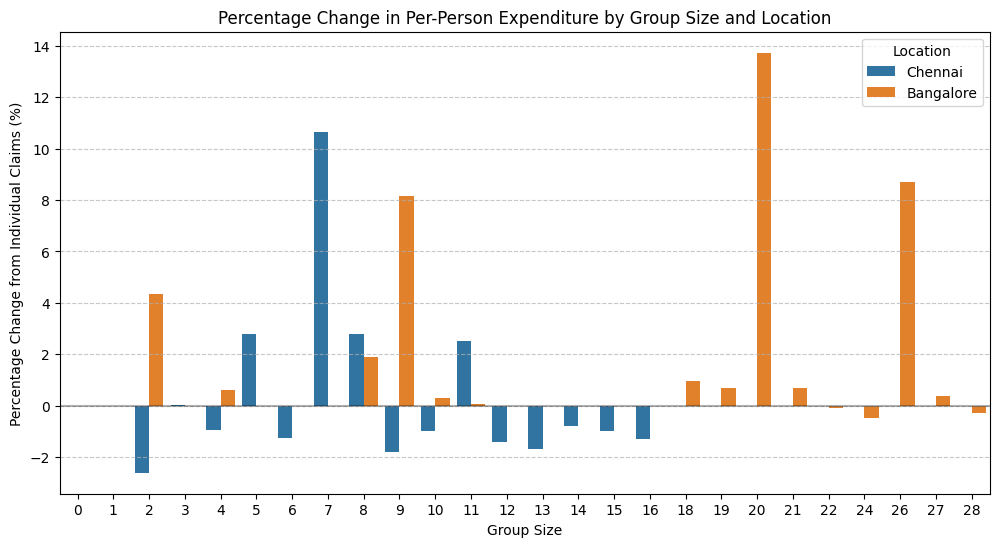

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(data=location_analysis, x='Group_Size', y='Percentage_Change', hue='Location')
plt.title('Percentage Change in Per-Person Expenditure by Group Size and Location')
plt.xlabel('Group Size')
plt.ylabel('Percentage Change from Individual Claims (%)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.savefig('location_percentage_change.png')

In [25]:
# Convert Bill_Date_Friday to datetime if not already
df['Bill_Date_Friday'] = pd.to_datetime(df['Bill_Date_Friday'])

# Extract month and quarter
df['Month'] = df['Bill_Date_Friday'].dt.month_name()
df['Quarter'] = df['Bill_Date_Friday'].dt.quarter

# Monthly analysis
monthly_analysis = df.groupby(['Month', 'Total_Persons'])['Per_Person_Expenditure'].mean().reset_index()
monthly_analysis.columns = ['Month', 'Group_Size', 'Avg_Per_Person_Expenditure']

# Ensure months are in chronological order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
monthly_analysis['Month'] = pd.Categorical(monthly_analysis['Month'], categories=month_order, ordered=True)
monthly_analysis = monthly_analysis.sort_values(['Month', 'Group_Size'])

# Quarterly analysis
quarterly_analysis = df.groupby(['Quarter', 'Total_Persons'])['Per_Person_Expenditure'].mean().reset_index()
quarterly_analysis.columns = ['Quarter', 'Group_Size', 'Avg_Per_Person_Expenditure']


<Figure size 1400x800 with 0 Axes>

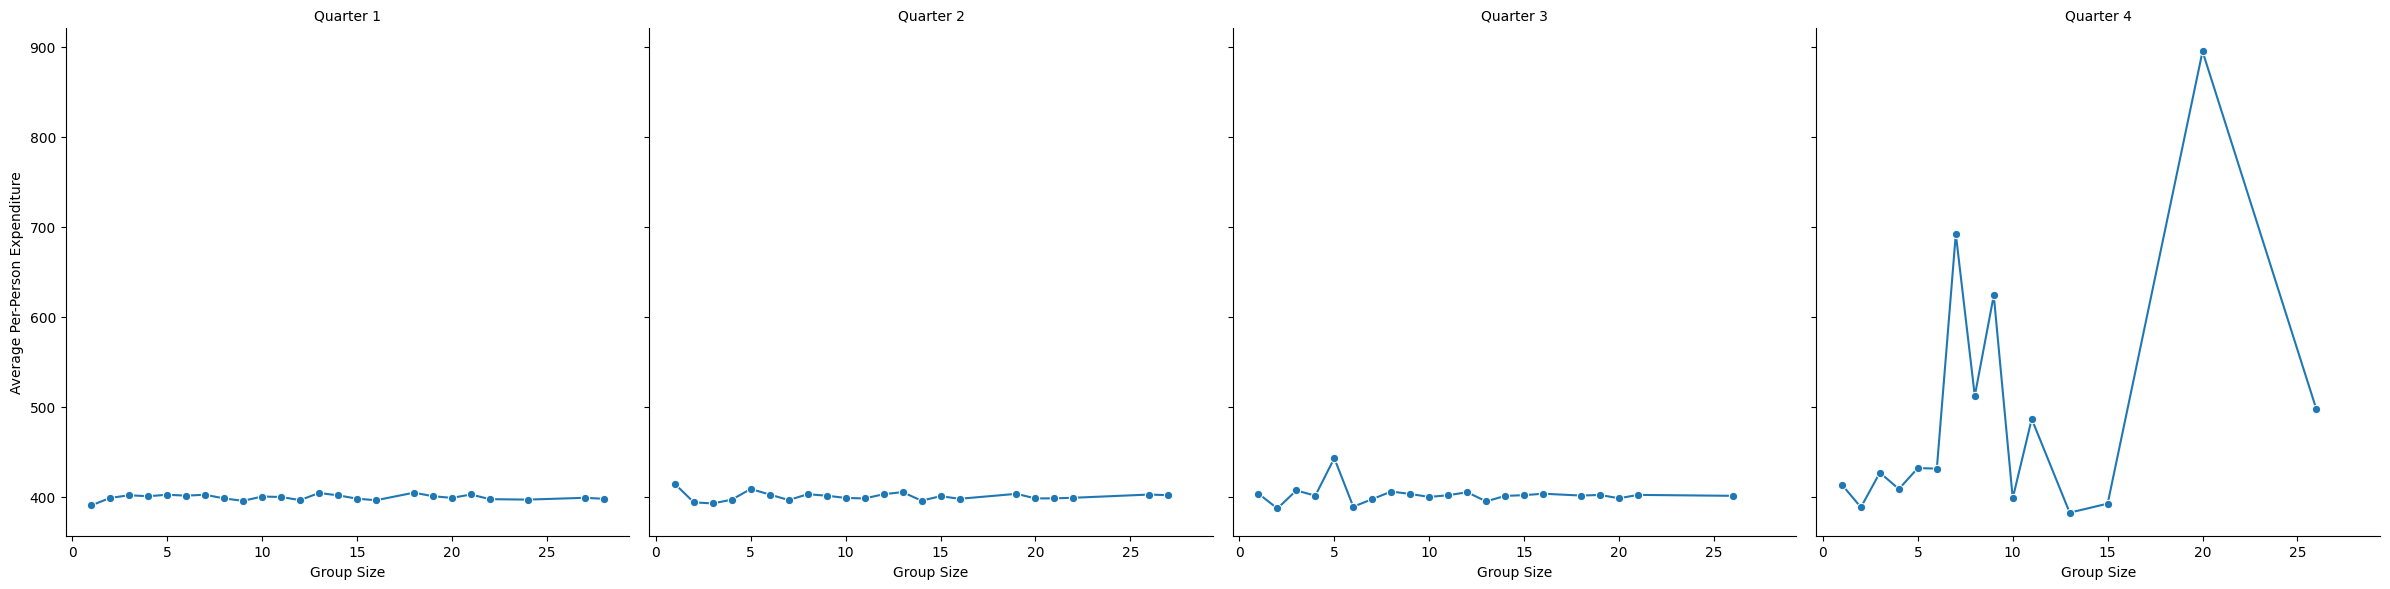

In [27]:
plt.figure(figsize=(14, 8))
g = sns.FacetGrid(quarterly_analysis, col='Quarter', height=6, aspect=1)
g.map_dataframe(sns.lineplot, x='Group_Size', y='Avg_Per_Person_Expenditure', marker='o')
g.set_axis_labels('Group Size', 'Average Per-Person Expenditure')
g.set_titles('Quarter {col_name}')
g.tight_layout()

In [30]:
# Calculate the percentage change for each month
monthly_bases = monthly_analysis[monthly_analysis['Group_Size'] == 1].set_index('Month')['Avg_Per_Person_Expenditure'].to_dict()
monthly_analysis['Base_Value'] = monthly_analysis['Month'].map(monthly_bases).astype('int64')
monthly_analysis['Percentage_Change'] = ((monthly_analysis['Avg_Per_Person_Expenditure'] - monthly_analysis['Base_Value']) / 
                                        monthly_analysis['Base_Value'] * 100).round(2)


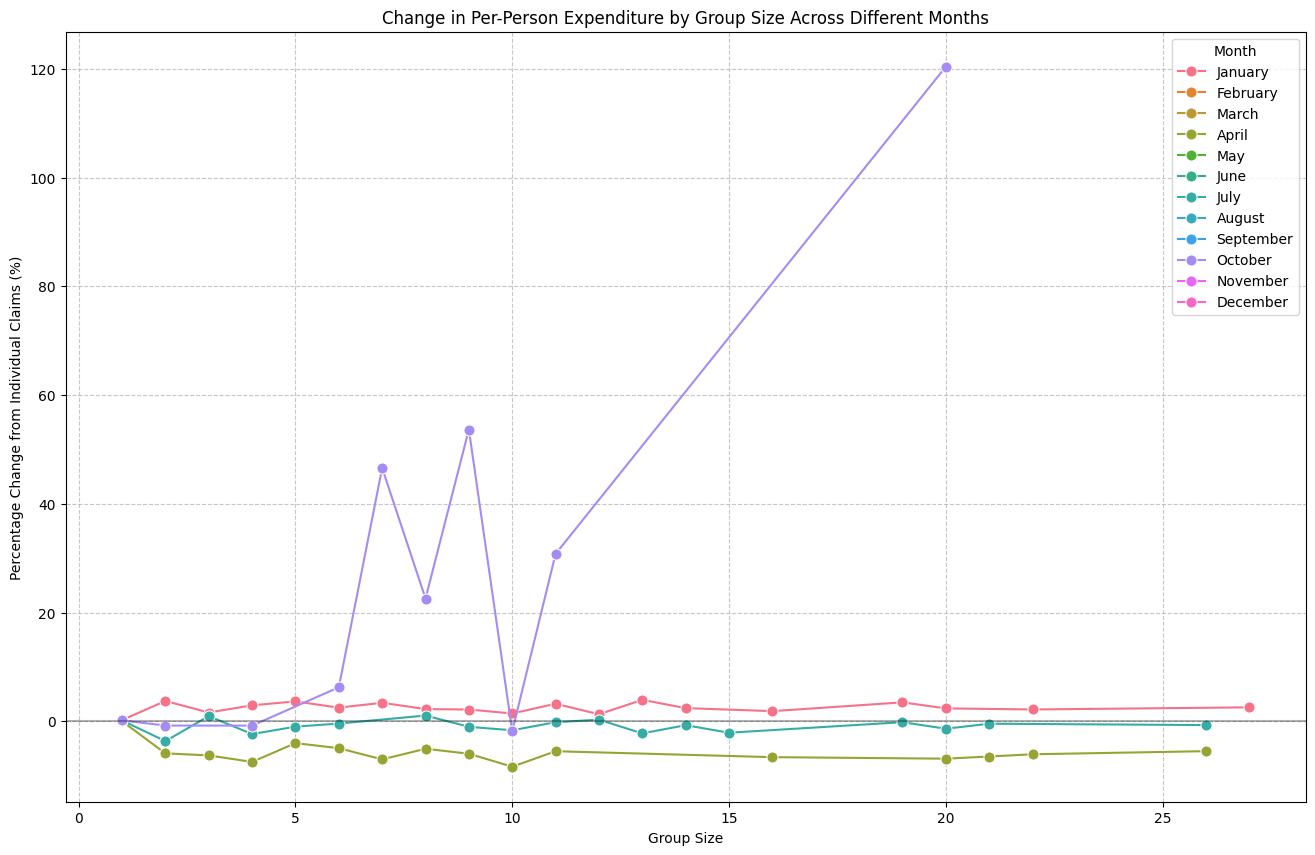

In [31]:
# Create a visualization to show how the relationship changes over months
plt.figure(figsize=(16, 10))
months_to_plot = ['January', 'April', 'July', 'October']  # Select representative months
monthly_subset = monthly_analysis[monthly_analysis['Month'].isin(months_to_plot)]

sns.lineplot(data=monthly_subset, x='Group_Size', y='Percentage_Change', hue='Month', marker='o', markersize=8)
plt.title('Change in Per-Person Expenditure by Group Size Across Different Months')
plt.xlabel('Group Size')
plt.ylabel('Percentage Change from Individual Claims (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

In [32]:
print("\nTemporal Analysis Results:")
for quarter, data in quarterly_analysis.groupby('Quarter'):
    print(f"\nQuarter {quarter}:")
    print(data[['Group_Size', 'Avg_Per_Person_Expenditure']])


Temporal Analysis Results:

Quarter 1:
    Group_Size  Avg_Per_Person_Expenditure
0            1                  390.528090
1            2                  398.880952
2            3                  401.777778
3            4                  400.697368
4            5                  402.360000
5            6                  401.343750
6            7                  402.380952
7            8                  398.250000
8            9                  395.589744
9           10                  400.368421
10          11                  399.867133
11          12                  396.385417
12          13                  404.307692
13          14                  401.704082
14          15                  398.000000
15          16                  396.250000
16          18                  404.638889
17          19                  400.754386
18          20                  398.850000
19          21                  402.650794
20          22                  397.454545
21          24

In [33]:
consistency_scores = {}
for month in month_order:
    month_data = df[df['Month'] == month]
    if len(month_data) > 0:
        corr = month_data['Total_Persons'].corr(month_data['Per_Person_Expenditure'])
        consistency_scores[month] = corr

# Find months with strongest and weakest correlations
strongest_month = min(consistency_scores.items(), key=lambda x: x[1])[0]
weakest_month = max(consistency_scores.items(), key=lambda x: x[1])[0]

print(f"\nMonth with strongest negative correlation: {strongest_month} ({consistency_scores[strongest_month]:.4f})")
print(f"Month with weakest correlation: {weakest_month} ({consistency_scores[weakest_month]:.4f})")


Month with strongest negative correlation: April (-0.1908)
Month with weakest correlation: October (0.6136)


c:\Users\DYNABOOK\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_function_base_impl.py:2888: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
